In [1]:
print('Arabic Font Classification Project!!')

Arabic Font Classification Project!!


# Classification Methods
In this lab, it is required to identify between different hand-drawn shapes; such as rectangles, circles, triangles, ellipses, polygons, etc.

We will start our first lab in this course by understanding the main pipeline of any machine learning project:

**Important Note:** **Read all the code and fill the required functions in the 'utils' notebook as you go.**

In [2]:
#Always make all imports in the first cell of the notebook, run them all once.
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from __future__ import division
import numpy as np
from scipy.signal import convolve2d
from sklearn import svm ,metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.utils import shuffle

# for NN:
import keras
from keras.models import Sequential
from keras.layers import Dense


%matplotlib inline

# A Machine Learning (ML) project is divided into many stages:

## 1. Gathering Data (Data Acquisition):

The first real step of machine learning is gathering data. This step is very important because the **quality and quantity** of data that you gather will directly determine how good your predictive model can be.

We define placeholders for the data as follows: 
* **x_train:** This represents the images in the training set. 
* **y_train:** This represents the labels of the images in the training set.  

In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
styles = []

In [4]:
# load styles names:
with open('ACdata_base/names.txt') as file:
    lines = file.readlines()
    styles = [line.rstrip()[4:] for line in lines] # ignoring number at first of each style (first 4 chars)
print(styles)


['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']


In [5]:
## load styles images:
x=[]
y=[]
for i in range(1, len(styles)+1):
    for filename in sorted(glob.glob('ACdata_base/'+str(i)+'/*.jpg')):
        img = cv2.imread(filename) ## cv2.imread reads images in RGB format
        x_train.append(img)
        y_train.append(i-1)
        # x.append(img)
        # y.append(i-1)

# for i in range(1, len(styles)+1):
#     for filename in sorted(glob.glob('ACdata_base_test/'+str(i)+'/*.jpg')):
#         img = cv2.imread(filename) ## cv2.imread reads images in RGB format
#         x_test.append(img)
#         y_test.append(i-1)

In [6]:
# A good practice is to convert lists into numpy arrays. When it comes to actual machine learning algorithms, 
# it is better to work with NumPy arrays.
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
#x_train = x_train.reshape(-1,1)
#y_train = y_train.reshape(-1,1)

print ("The size of the training set is: ", x_train.shape)

# We have a lot of images of different arabic styles, where each image is an RGB image of dimensions 200x200x3. 
# (images, height, width, channels)

print ("The size of the labels of the training set is: ", y_train.shape)
print (y_train)

The size of the training set is:  (1685,)
The size of the labels of the training set is:  (1685,)
[0 0 0 ... 8 8 8]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


We will now visualize this dataset. 

**Note: You can run the following cell multiple times to view different shapes in the dataset as well as the ground-truth value associated with this training image.**

The ground-truth value of this image is:  diwani


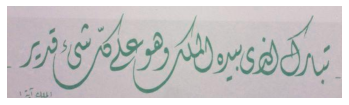

In [7]:
# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image.
plt.imshow(x_train[random_index])
plt.axis("off")

print("The ground-truth value of this image is: " , styles[y_train[random_index]])

- - -
# 2. Data Preprocessing:

The second stage is to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis. We need to prepare it to be suitable for our problem.

In this step, we will apply preprocessing to the images in **x_train** as follows: 
   1. Convert RGB images to grayscale images. Use the function **cv2.cvtColor** 
   2. Remove noise in images by blurring (averaging). Use the function **cv2.blur**
   3. Applying a binary threshold on the image pixels. Use the function **cv2.threshold**. The pixels having intensity less than this threshold should be considered black pixels, and white otherwise. 

In [8]:
def preprocess(img):
    # Preprocess the given image img.
    #-----------------------------------------------------------------------------------------------
    # Convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #-----------------------------------------------------------------------------------------------
    #Convert the grayscale image to a binary image. Apply a threshold using Otsu's method on the blurred image.
    # get the threshold of the image using Otsu's method
    thresh = threshold_otsu(gray)
    thresholded_img = gray > thresh
    #_, thresholded_img = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    #-----------------------------------------------------------------------------------------------
    return thresholded_img

In [9]:
# We will apply the function you implemented for each image in the training set (x_train) 
# and add the pre-processed images to a new list (x_train_preprocessed.)
x_train_preprocessed = []
for i in range(x_train.shape[0]):
    preprocessed_img = preprocess(x_train[i])
    x_train_preprocessed.append(preprocessed_img)


In [10]:
x_train_preprocessed = np.asarray(x_train_preprocessed)

shape = x_train_preprocessed.shape 

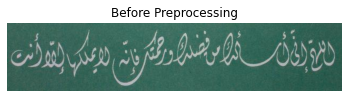

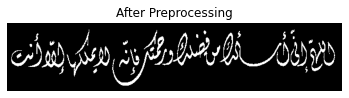

In [11]:
# Let's visualize what happened after preprocessing 

# Generate a random index from 0 to 18 inclusive. 
random_index = np.random.randint(0,18)

# Plot the image before preprocessing.
plt.imshow(x_train[random_index],cmap='gray')
plt.axis("off")
plt.title("Before Preprocessing")
plt.show()

# Plot the image after preprocessing.
plt.imshow(x_train_preprocessed[random_index],cmap='gray')
plt.axis("off")
plt.title("After Preprocessing")
plt.show()


In [12]:
# We do not need the original x_train anymore. We will work on x_train_preprocessed from now on. 
x_train = x_train_preprocessed


- - -
# 3. Feature Extraction: 

Now that we have clean and preprocessed data, we can use it to solve our classification problem.

This step could be either:
    
* **Feature Engineering:** transformation of raw data into features suitable for modeling.

* **Feature Transformation:** transformation of data to improve the accuracy of the algorithm.

* **Feature Selection:** removing unnecessary features.
    
The process of feature extraction in our problem can have many designs:

* One design is to extract the number of black pixels compared to the number of white pixels in each image and use this feature to differentiate between different shapes. (Is this a powerful feature?) Can you think of other features?


A more powerful set of features can be obtained by computing the convex hull of these shapes, and compare the area of this convex hull with the minimum enclosing circle, minimum enclosing rectangle and minimum enclosing triangle bounding that figure.


In the example above, the ratio between the areas of the convex hull (traingular figure) to the area of the bounding triangle will be maximum, and relatively smaller for the bounding rectangle and circle respectively. 

On the other hand, if the given shape was a circle, then the ratio between the areas of the shape to the bounding circle will be maximum and smaller for the bounding rectangle and triangle. 

Therefore, each image will be represented with a feature vector in three dimensions **(x, y and z)** where each component represents the ratio between the area of the figure to the area of the bounding rectangle, circle and triangle respectively.

**The images in the example above can be represented as a feature vector (0.67, 0.58, 0.92)**

We will now implement all functions needed for feature extraction.

In [13]:
# LPQ "Local Phase Quantization" Feature Extraction:
def lpq(img,winSize=5,freqestim=1,mode='nh'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    #print(LPQdesc)
    return LPQdesc

We finally populate the array **training_features** with the extracted features from each image using the functions you implemented earlier. 

## Visualize the Features
A very useful step here is to visualize your features, see how they separate different classes from one another, and how they group data points from the same class closer together.

In [14]:
features = [lpq(x,winSize=5) for x in x_train]
features= np.array(features)

- - -
# 4. ML Model: 
It’s time to feed the crafted features to the classification algorithm that is going to classify or predict the class of unknown or newly unseen data (called testing data). The process of choosing which classification algorithm will yield the best results is not an easy one. It is often subject to many iterations of tuning parameters and features.

In this lab, we will apply three classification algorithms and compare their results:
1. **SVM.**
2. **Radnom Forest.**
3. **K-Nearest Neighbour Classifier.**
3. **Neural Network as a Classifier.**


In [26]:
#SVM CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].
def svmCLF(feats,y_lbl,test_x,test_y):
    clf = svm.SVC(kernel='poly',degree=2,C=500)
    print(feats.shape)
    clf.fit(feats, y_lbl)
    y_preds = clf.predict(test_x)
        
    ascore = metrics.accuracy_score(test_y, y_preds)
    pscore = metrics.precision_score(test_y, y_preds,average='weighted')
    rscore = metrics.recall_score(test_y, y_preds,average='weighted')
    fscore = metrics.f1_score(test_y, y_preds,average='weighted')
    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore
#svmCLF(features,y_train,x_test,y_test)


In [27]:
# KNN CLASSIFIER
def KNNCLF(feats,y_lbl,test_x,test_y):

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(feats, y_lbl)
    y_predk = clf.predict(test_x)
    ascore = metrics.accuracy_score(test_y, y_predk)
    pscore = metrics.precision_score(test_y, y_predk,average='weighted')
    rscore = metrics.recall_score(test_y, y_predk,average='weighted')
    fscore = metrics.f1_score(test_y, y_predk,average='weighted')
    
    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore
# KNNCLF(features,y_train,x_test,y_test)

In [28]:
# Random Forest Tree CLASSIFIER

# average setting, one of [None, 'micro', 'macro', 'weighted'].
def RFCLF(feats,y_lbl,test_x,test_y):
    clf = RandomForestClassifier(max_depth=13, random_state=3,n_estimators=500)
    print(feats.shape)
    clf.fit(feats, y_lbl)
    y_predr = clf.predict(test_x)
    ascore = metrics.accuracy_score(test_y, y_predr)
    pscore = metrics.precision_score(test_y, y_predr,average='weighted')
    rscore = metrics.recall_score(test_y, y_predr,average='weighted')
    fscore = metrics.f1_score(test_y, y_predr,average='weighted')

    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore

# RFCLF(features,y_train,x_test,y_test)

In [29]:
# Neural network as a Classifier:

def NeuralCLF(feats,y_lbl,test_x,test_y):
    model = Sequential()
    model.add(Dense(16, input_dim=len(feats[0]), activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    y_lbl=np.asarray(y_lbl).astype(np.float32)
    feats = np.asarray(feats).astype(np.float32)
    history = model.fit(feats, y_lbl, epochs=1000, batch_size=255)

    y_prednn = model.predict(test_x)
    y_prednn_labels = np.argmax(y_prednn,axis=1)
    ascore = metrics.accuracy_score(test_y, y_prednn_labels)
    pscore = metrics.precision_score(test_y, y_prednn_labels,average='weighted')
    rscore = metrics.recall_score(test_y, y_prednn_labels,average='weighted')
    fscore = metrics.f1_score(test_y, y_prednn_labels,average='weighted')

    print("Accuracy:",round(ascore*100,2) ,'%')
    print("Precision:",round(pscore*100,2),'%')
    print("Recall:",round(rscore*100,2),'%')
    print("f1 score:",round(fscore*100,2),'%')

    return ascore,pscore,rscore,fscore

- - -
# 5. Cross Validation: 
We will use K-fold for cross validation since our data is limited
divindg our data in to k arrays
Training k-1 arrays 
Testing on 1 array

Repeat k permutations on our data set

### Computing Means:
We check for each classifiers' `mean` to check for the best accuracies
classfieirs:
-   SVM
-   RF
-   KNN
-   Neural Network

In [30]:
# Our k-fold returns batches of random folds
def KFold(K,x_train,y_train,seed=0):
    fold_size = round(len(x_train)/K)
    
    x_fold = []# np.zeros((fold_size,1))
    y_fold = []#np.zeros((fold_size,1))
    #random.shuffle(x_train)
    
    x_shuff, y_shuff = shuffle(x_train, y_train, random_state=seed)

    for j in range(K): #10 times
        tempx = []
        tempy = []
        for i in range(j*fold_size,fold_size*(j+1)):
            tempx.append(x_shuff[i])
            tempy.append(y_shuff[i])
        y_fold.append(tempy)
        x_fold.append(tempx)
        print(len(tempx))

        
    # y_fold = np.array(y_fold)
    # x_fold = np.array(x_fold)

    return x_fold,y_fold

# xf,yf = KFold(10,x,y)
# print(xf.shape)


    #random.shuffle(array)

In [41]:
x_fold,y_fold = KFold(10,features,y_train,2)

x_train_f=[]
y_train_f=[]
y_train_nn_f=[]
x_test =[]
y_test = []
for index,_ in enumerate(x_fold): #assiging 10[168]
    if(i==index):
        x_test = x_fold[index]
        y_test = y_fold[index]
    else:
        x_train_f.extend(x_fold[index])
        y_train_f.extend(y_fold[index])
#convert y_train to y_train_nn for NN
for fold_ele in y_train_f:
    ynn = np.zeros(len(styles),dtype='float32')
    ynn[fold_ele] = 1.0
    y_train_nn_f.append(ynn)
x_train_f=np.array(x_train_f)
y_train_f=np.array(y_train_f)
y_train_nn_f=np.array(y_train_nn_f)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(y_train_f.shape)
print(y_train_nn_f.shape)
#NN_score,pn,rn,fn = NeuralCLF(x_train_f,y_train_nn_f,x_test,y_test)

168
168
168
168
168
168
168
168
168
168
(1680,)
(1680, 9)


In [44]:
# x and y passed by k-fold 10 since it's recommended
# Trying it out on svm first
## svm-> x_fold 0-8 x_test=x_fold[9]
def Kprocessing(k,x_fold,y_fold):
    svm_Scores=[]
    KNN_scores=[]
    RF_scores= []
    NN_scores= []
    for i in range(k): #loop 10 times
        x_train_f=[]
        y_train_f=[]
        y_train_nn_f=[]
        x_test =[]
        y_test = []
        for index,_ in enumerate(x_fold): #assiging 10[168]
            if(i==index):
                x_test = x_fold[index]
                y_test = y_fold[index]
            else:
                x_train_f.extend(x_fold[index])
                y_train_f.extend(y_fold[index])
        #convert y_train to y_train_nn for NN
        for fold_ele in y_train_f:
            ynn = np.zeros(len(styles),dtype='float32')
            ynn[fold_ele] = 1.0
            y_train_nn_f.append(ynn)
        x_train_f=np.array(x_train_f)
        y_train_f=np.array(y_train_f)
        y_train_nn_f=np.array(y_train_nn_f)
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        # Get scores for each classifiers aprf
        svm_score,ps,rs,fs = svmCLF(x_train_f,y_train_f,x_test,y_test)
        KNN_score,pk,rk,fk = KNNCLF(x_train_f,y_train_f,x_test,y_test)
        RF_score,pr,rr,fr = RFCLF(x_train_f,y_train_f,x_test,y_test)
        NN_score,pn,rn,fn = NeuralCLF(x_train_f,y_train_nn_f,x_test,y_test)

        # appending scores
        svm_Scores.append([svm_score,ps,rs,fs])
        KNN_scores.append([KNN_score,pk,rk,fk])
        RF_scores.append([RF_score,pr,rr,fr])
        NN_scores.append([NN_score,pn,rn,fn])
        
    # converting to np arrays
    svm_Scores=np.array(svm_Scores)
    KNN_scores=np.array(KNN_scores)
    RF_scores=np.array(RF_scores)
    NN_scores=np.array(NN_scores)

    # computing mean accuracies
    svm_meana = np.mean(svm_Scores[:,0])
    KNN_meana = np.mean(KNN_scores[:,0])
    RF_meana = np.mean(RF_scores[:,0])
    NN_meana = np.mean(NN_scores[:,0])

    # computing mean precision
    svm_meanp = np.mean(svm_Scores[:,1])
    KNN_meanp = np.mean(KNN_scores[:,1])
    RF_meanp = np.mean(RF_scores[:,1])
    NN_meanp = np.mean(NN_scores[:,1])
    
    # computing mean recall
    svm_meanr = np.mean(svm_Scores[:,2])
    KNN_meanr = np.mean(KNN_scores[:,2])
    RF_meanr = np.mean(RF_scores[:,2])
    NN_meanr = np.mean(NN_scores[:,2])

    # computing mean F1
    svm_meanf = np.mean(svm_Scores[:,3])
    KNN_meanf = np.mean(KNN_scores[:,3])
    RF_meanf = np.mean(RF_scores[:,3])
    NN_meanf = np.mean(NN_scores[:,3])

    #appending each score means for each clf
    svm_Real_score = [svm_meana,svm_meanp,svm_meanr,svm_meanf]
    KNN_Real_score = [KNN_meana,KNN_meanp,KNN_meanr,KNN_meanf]
    RF_Real_score = [RF_meana,RF_meanp,RF_meanr,RF_meanf]
    NN_Real_score = [NN_meana,NN_meanp,NN_meanr,NN_meanf]

    return(svm_Real_score,KNN_Real_score,RF_Real_score,NN_Real_score)
    




In [45]:
# Proccessing the K-fold
x_fold,y_fold = KFold(10,features,y_train,2)
svm_real_score,knn_real_score,rf_real_score,nn_real_score = Kprocessing(10,x_fold,y_fold)

168
168
168
168
168
168
168
168
168
168
(1512, 255)
Accuracy: 98.21 %
Precision: 98.35 %
Recall: 98.21 %
f1 score: 98.23 %
Accuracy: 83.93 %
Precision: 84.56 %
Recall: 83.93 %
f1 score: 83.83 %
(1512, 255)
Accuracy: 99.4 %
Precision: 99.44 %
Recall: 99.4 %
f1 score: 99.41 %
Epoch 1/1000
6/6 [==============================] - 1s 7ms/step - loss: 2.1978 - accuracy: 0.1104
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1733
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1912 - accuracy: 0.2209
Epoch 4/1000
6/6 [==============================] - ETA: 0s - loss: 2.1897 - accuracy: 0.22 - 0s 7ms/step - loss: 2.1884 - accuracy: 0.2302
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1860 - accuracy: 0.2870
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1831 - accuracy: 0.2851
Epoch 7/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1800 - accuracy: 0.28

6/6 [==============================] - 0s 8ms/step - loss: 1.2856 - accuracy: 0.5999
Epoch 81/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2765 - accuracy: 0.6005
Epoch 82/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2676 - accuracy: 0.6111
Epoch 83/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2592 - accuracy: 0.6118
Epoch 84/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2511 - accuracy: 0.6091
Epoch 85/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2431 - accuracy: 0.6151
Epoch 86/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2348 - accuracy: 0.6144
Epoch 87/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2269 - accuracy: 0.6098
Epoch 88/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2192 - accuracy: 0.6157
Epoch 89/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2118 - accuracy: 0.6184
Epoch 90/1000
6/6 [===

6/6 [==============================] - 0s 8ms/step - loss: 0.8904 - accuracy: 0.7163
Epoch 162/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8876 - accuracy: 0.7196
Epoch 163/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8850 - accuracy: 0.7176
Epoch 164/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8823 - accuracy: 0.7183
Epoch 165/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8795 - accuracy: 0.7235
Epoch 166/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8769 - accuracy: 0.7183
Epoch 167/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8741 - accuracy: 0.7196
Epoch 168/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.8716 - accuracy: 0.7209
Epoch 169/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8690 - accuracy: 0.7209
Epoch 170/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8664 - accuracy: 0.7235
Epoch 171/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.7130 - accuracy: 0.7817
Epoch 243/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7107 - accuracy: 0.7824
Epoch 244/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7089 - accuracy: 0.7824
Epoch 245/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7070 - accuracy: 0.7857
Epoch 246/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7049 - accuracy: 0.7857
Epoch 247/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7034 - accuracy: 0.7831
Epoch 248/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7017 - accuracy: 0.7844
Epoch 249/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6999 - accuracy: 0.7923
Epoch 250/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6973 - accuracy: 0.7917
Epoch 251/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6955 - accuracy: 0.7851
Epoch 252/1000


6/6 [==============================] - 0s 13ms/step - loss: 0.5499 - accuracy: 0.8261
Epoch 325/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5477 - accuracy: 0.8287
Epoch 326/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5460 - accuracy: 0.8294
Epoch 327/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.5439 - accuracy: 0.8300
Epoch 328/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5424 - accuracy: 0.8294
Epoch 329/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5405 - accuracy: 0.8307
Epoch 330/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.5384 - accuracy: 0.8307
Epoch 331/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5367 - accuracy: 0.8333
Epoch 332/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.5349 - accuracy: 0.8313
Epoch 333/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.5336 - accuracy: 0.8294
Epoch 334/10

6/6 [==============================] - 0s 9ms/step - loss: 0.4274 - accuracy: 0.8624
Epoch 405/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4261 - accuracy: 0.8598
Epoch 406/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4250 - accuracy: 0.8611
Epoch 407/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4239 - accuracy: 0.8638
Epoch 408/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4231 - accuracy: 0.8638
Epoch 409/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4215 - accuracy: 0.8638
Epoch 410/1000
6/6 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.87 - 0s 8ms/step - loss: 0.4203 - accuracy: 0.8644
Epoch 411/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4191 - accuracy: 0.8657
Epoch 412/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4180 - accuracy: 0.8671
Epoch 413/1000
6/6 [==============================] - 0s 8ms/step - loss:

6/6 [==============================] - 0s 8ms/step - loss: 0.3534 - accuracy: 0.8803
Epoch 484/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3525 - accuracy: 0.8843
Epoch 485/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3520 - accuracy: 0.8856
Epoch 486/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3506 - accuracy: 0.8862
Epoch 487/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3499 - accuracy: 0.8882
Epoch 488/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3494 - accuracy: 0.8869
Epoch 489/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3483 - accuracy: 0.8856
Epoch 490/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3476 - accuracy: 0.8882
Epoch 491/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3468 - accuracy: 0.8882
Epoch 492/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3462 - accuracy: 0.8882
Epoch 493/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.2987 - accuracy: 0.9008
Epoch 564/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2981 - accuracy: 0.8995
Epoch 565/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2973 - accuracy: 0.9028
Epoch 566/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2967 - accuracy: 0.9021
Epoch 567/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2963 - accuracy: 0.9008
Epoch 568/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2960 - accuracy: 0.9028
Epoch 569/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2950 - accuracy: 0.9028
Epoch 570/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2941 - accuracy: 0.9034
Epoch 571/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2935 - accuracy: 0.9041
Epoch 572/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2929 - accuracy: 0.9021
Epoch 573/1000

6/6 [==============================] - 0s 8ms/step - loss: 0.2529 - accuracy: 0.9193
Epoch 645/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2521 - accuracy: 0.9213
Epoch 646/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.9239
Epoch 647/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2512 - accuracy: 0.9233
Epoch 648/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2508 - accuracy: 0.9226
Epoch 649/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2502 - accuracy: 0.9226
Epoch 650/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2499 - accuracy: 0.9206
Epoch 651/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2492 - accuracy: 0.9206
Epoch 652/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2493 - accuracy: 0.9239
Epoch 653/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2486 - accuracy: 0.9239
Epoch 654/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.2138 - accuracy: 0.9358
Epoch 726/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2130 - accuracy: 0.9385
Epoch 727/1000
6/6 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2127 - accuracy: 0.9385
Epoch 728/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.2124 - accuracy: 0.9365
Epoch 729/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.2118 - accuracy: 0.9358
Epoch 730/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2113 - accuracy: 0.9392
Epoch 731/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.2109 - accuracy: 0.9378
Epoch 732/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2103 - accuracy: 0.9392
Epoch 733/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2100 - accuracy: 0.9405
Epoch 734/1000
6/6 [==============================] - 0s 8ms/step - lo

6/6 [==============================] - 0s 8ms/step - loss: 0.1802 - accuracy: 0.9491
Epoch 807/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1786 - accuracy: 0.9491
Epoch 808/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1783 - accuracy: 0.9471
Epoch 809/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.9484
Epoch 810/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1773 - accuracy: 0.9497
Epoch 811/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1767 - accuracy: 0.9497
Epoch 812/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1764 - accuracy: 0.9504
Epoch 813/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1761 - accuracy: 0.9491
Epoch 814/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1760 - accuracy: 0.9504
Epoch 815/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1759 - accuracy: 0.9497
Epoch 816/1000

6/6 [==============================] - 0s 8ms/step - loss: 0.1488 - accuracy: 0.9636
Epoch 889/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1487 - accuracy: 0.9636
Epoch 890/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1483 - accuracy: 0.9649
Epoch 891/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1482 - accuracy: 0.9643
Epoch 892/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1476 - accuracy: 0.9649
Epoch 893/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1476 - accuracy: 0.9649
Epoch 894/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1472 - accuracy: 0.9649
Epoch 895/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1465 - accuracy: 0.9643
Epoch 896/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.9643
Epoch 897/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1460 - accuracy: 0.9656
Epoch 898/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9769
Epoch 970/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1246 - accuracy: 0.9735
Epoch 971/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1249 - accuracy: 0.9742
Epoch 972/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1240 - accuracy: 0.9749
Epoch 973/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1238 - accuracy: 0.9749
Epoch 974/1000
6/6 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.97 - 0s 9ms/step - loss: 0.1235 - accuracy: 0.9762
Epoch 975/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1233 - accuracy: 0.9735
Epoch 976/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.9735
Epoch 977/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1228 - accuracy: 0.9755
Epoch 978/1000
6/6 [==============================] - 0s 8ms/step - loss:

6/6 [==============================] - 0s 7ms/step - loss: 1.6268 - accuracy: 0.4206
Epoch 49/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.6171 - accuracy: 0.4220
Epoch 50/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6073 - accuracy: 0.4259
Epoch 51/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.5979 - accuracy: 0.4299
Epoch 52/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.5884 - accuracy: 0.4325
Epoch 53/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.5793 - accuracy: 0.4372
Epoch 54/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.5704 - accuracy: 0.4385
Epoch 55/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5613 - accuracy: 0.4418
Epoch 56/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5526 - accuracy: 0.4431
Epoch 57/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5441 - accuracy: 0.4438
Epoch 58/1000
6/6 [====

6/6 [==============================] - 0s 8ms/step - loss: 1.0923 - accuracy: 0.6528
Epoch 131/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0871 - accuracy: 0.6561
Epoch 132/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0817 - accuracy: 0.6574
Epoch 133/1000
6/6 [==============================] - ETA: 0s - loss: 1.1132 - accuracy: 0.62 - 0s 10ms/step - loss: 1.0760 - accuracy: 0.6554
Epoch 134/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0710 - accuracy: 0.6528
Epoch 135/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0659 - accuracy: 0.6567
Epoch 136/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0606 - accuracy: 0.6574
Epoch 137/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0554 - accuracy: 0.6601
Epoch 138/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0499 - accuracy: 0.6581
Epoch 139/1000
6/6 [==============================] - 0s 10ms/step - los

6/6 [==============================] - 0s 8ms/step - loss: 0.8033 - accuracy: 0.7308
Epoch 212/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8009 - accuracy: 0.7328
Epoch 213/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7990 - accuracy: 0.7328
Epoch 214/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7968 - accuracy: 0.7368
Epoch 215/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7948 - accuracy: 0.7348
Epoch 216/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7925 - accuracy: 0.7368
Epoch 217/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7906 - accuracy: 0.7388
Epoch 218/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7887 - accuracy: 0.7394
Epoch 219/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7865 - accuracy: 0.7374
Epoch 220/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7846 - accuracy: 0.7388
Epoch 221/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.6633 - accuracy: 0.7877
Epoch 292/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6617 - accuracy: 0.7910
Epoch 293/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6600 - accuracy: 0.7903
Epoch 294/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6589 - accuracy: 0.7910
Epoch 295/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6573 - accuracy: 0.7910
Epoch 296/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6550 - accuracy: 0.7890
Epoch 297/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6537 - accuracy: 0.7930
Epoch 298/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6521 - accuracy: 0.7923
Epoch 299/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6504 - accuracy: 0.7937
Epoch 300/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6485 - accuracy: 0.7930
Epoch 301/1000


Epoch 373/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5176 - accuracy: 0.8300
Epoch 374/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.8380
Epoch 375/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5137 - accuracy: 0.8360
Epoch 376/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5120 - accuracy: 0.8333
Epoch 377/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5101 - accuracy: 0.8366
Epoch 378/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5085 - accuracy: 0.8360
Epoch 379/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5066 - accuracy: 0.8380
Epoch 380/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5047 - accuracy: 0.8386
Epoch 381/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5033 - accuracy: 0.8347
Epoch 382/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5011 - accuracy: 0.8406

6/6 [==============================] - 0s 7ms/step - loss: 0.4000 - accuracy: 0.8624
Epoch 455/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3992 - accuracy: 0.8638
Epoch 456/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3977 - accuracy: 0.8644
Epoch 457/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3970 - accuracy: 0.8644
Epoch 458/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3961 - accuracy: 0.8644
Epoch 459/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3951 - accuracy: 0.8638
Epoch 460/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3941 - accuracy: 0.8644
Epoch 461/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3931 - accuracy: 0.8644
Epoch 462/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3921 - accuracy: 0.8651
Epoch 463/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3914 - accuracy: 0.8657
Epoch 464/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3369 - accuracy: 0.8816
Epoch 536/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3361 - accuracy: 0.8829
Epoch 537/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3354 - accuracy: 0.8856
Epoch 538/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3350 - accuracy: 0.8843
Epoch 539/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8829
Epoch 540/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3337 - accuracy: 0.8849
Epoch 541/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3333 - accuracy: 0.8869
Epoch 542/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3324 - accuracy: 0.8862
Epoch 543/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3318 - accuracy: 0.8836
Epoch 544/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3315 - accuracy: 0.8856
Epoch 545/1000


Epoch 617/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2926 - accuracy: 0.8995
Epoch 618/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2919 - accuracy: 0.9001
Epoch 619/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2914 - accuracy: 0.9015
Epoch 620/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2909 - accuracy: 0.9001
Epoch 621/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2904 - accuracy: 0.9021
Epoch 622/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2900 - accuracy: 0.9001
Epoch 623/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2892 - accuracy: 0.9021
Epoch 624/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2892 - accuracy: 0.9028
Epoch 625/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2888 - accuracy: 0.9021
Epoch 626/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2886 - accuracy: 0.904

6/6 [==============================] - 0s 8ms/step - loss: 0.2551 - accuracy: 0.9140
Epoch 699/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2544 - accuracy: 0.9140
Epoch 700/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2540 - accuracy: 0.9167
Epoch 701/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2535 - accuracy: 0.9173
Epoch 702/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2530 - accuracy: 0.9173
Epoch 703/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.2525 - accuracy: 0.9173
Epoch 704/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2520 - accuracy: 0.9173
Epoch 705/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.9160
Epoch 706/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2510 - accuracy: 0.9180
Epoch 707/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2511 - accuracy: 0.9167
Epoch 708/100

6/6 [==============================] - 0s 9ms/step - loss: 0.2186 - accuracy: 0.9299
Epoch 781/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2179 - accuracy: 0.9292
Epoch 782/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2178 - accuracy: 0.9292
Epoch 783/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.2171 - accuracy: 0.9312
Epoch 784/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2168 - accuracy: 0.9299
Epoch 785/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2164 - accuracy: 0.9319
Epoch 786/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2157 - accuracy: 0.9319
Epoch 787/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2153 - accuracy: 0.9299
Epoch 788/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2153 - accuracy: 0.9319
Epoch 789/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2146 - accuracy: 0.9325
Epoch 790/100

6/6 [==============================] - 0s 8ms/step - loss: 0.1831 - accuracy: 0.9411
Epoch 862/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1827 - accuracy: 0.9418
Epoch 863/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1821 - accuracy: 0.9431
Epoch 864/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1820 - accuracy: 0.9425
Epoch 865/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1823 - accuracy: 0.9431
Epoch 866/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.9438
Epoch 867/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1806 - accuracy: 0.9438
Epoch 868/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1803 - accuracy: 0.9411
Epoch 869/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.9418
Epoch 870/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1793 - accuracy: 0.9444
Epoch 871/1000


Epoch 943/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1496 - accuracy: 0.9577
Epoch 944/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1493 - accuracy: 0.9570
Epoch 945/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1494 - accuracy: 0.9577
Epoch 946/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1493 - accuracy: 0.9570
Epoch 947/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1488 - accuracy: 0.9563
Epoch 948/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1479 - accuracy: 0.9583
Epoch 949/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1477 - accuracy: 0.9577
Epoch 950/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1477 - accuracy: 0.9577
Epoch 951/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1471 - accuracy: 0.9563
Epoch 952/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1468 - accuracy: 0.957

6/6 [==============================] - 0s 7ms/step - loss: 2.0420 - accuracy: 0.2361
Epoch 23/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.0278 - accuracy: 0.2348
Epoch 24/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.0131 - accuracy: 0.2348
Epoch 25/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.9983 - accuracy: 0.2354
Epoch 26/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.9832 - accuracy: 0.2381
Epoch 27/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.9681 - accuracy: 0.2407
Epoch 28/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.9522 - accuracy: 0.2427
Epoch 29/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.9377 - accuracy: 0.2467
Epoch 30/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.9228 - accuracy: 0.2513
Epoch 31/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.9085 - accuracy: 0.2632
Epoch 32/1000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 1.3022 - accuracy: 0.5741
Epoch 104/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2945 - accuracy: 0.5767
Epoch 105/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.2871 - accuracy: 0.5774
Epoch 106/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2795 - accuracy: 0.5787
Epoch 107/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2719 - accuracy: 0.5794
Epoch 108/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2643 - accuracy: 0.5813
Epoch 109/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2569 - accuracy: 0.5813
Epoch 110/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.2497 - accuracy: 0.5827
Epoch 111/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.2428 - accuracy: 0.5866
Epoch 112/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2358 - accuracy: 0.5906
Epoch 113/10

6/6 [==============================] - 0s 8ms/step - loss: 0.9565 - accuracy: 0.6587
Epoch 185/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9541 - accuracy: 0.6587
Epoch 186/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9516 - accuracy: 0.6594
Epoch 187/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9491 - accuracy: 0.6574
Epoch 188/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9466 - accuracy: 0.6614
Epoch 189/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9441 - accuracy: 0.6607
Epoch 190/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9418 - accuracy: 0.6601
Epoch 191/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9395 - accuracy: 0.6614
Epoch 192/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9370 - accuracy: 0.6627
Epoch 193/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9349 - accuracy: 0.6614
Epoch 194/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.7969 - accuracy: 0.7044
Epoch 266/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7948 - accuracy: 0.7030
Epoch 267/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7933 - accuracy: 0.7050
Epoch 268/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7919 - accuracy: 0.7044
Epoch 269/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7900 - accuracy: 0.7057
Epoch 270/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7887 - accuracy: 0.7083
Epoch 271/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7871 - accuracy: 0.7063
Epoch 272/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7855 - accuracy: 0.7057
Epoch 273/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7839 - accuracy: 0.7057
Epoch 274/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7825 - accuracy: 0.7070
Epoch 275/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.6866 - accuracy: 0.7487
Epoch 348/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6852 - accuracy: 0.7460
Epoch 349/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6843 - accuracy: 0.7427
Epoch 350/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.6833 - accuracy: 0.7487
Epoch 351/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6819 - accuracy: 0.7507
Epoch 352/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6811 - accuracy: 0.7507
Epoch 353/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6795 - accuracy: 0.7487
Epoch 354/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6783 - accuracy: 0.7487
Epoch 355/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6772 - accuracy: 0.7560
Epoch 356/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6758 - accuracy: 0.7526
Epoch 357/10

6/6 [==============================] - 0s 8ms/step - loss: 0.5991 - accuracy: 0.7864
Epoch 430/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5986 - accuracy: 0.7817
Epoch 431/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5968 - accuracy: 0.7837
Epoch 432/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5959 - accuracy: 0.7870
Epoch 433/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5950 - accuracy: 0.7870
Epoch 434/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5939 - accuracy: 0.7844
Epoch 435/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5933 - accuracy: 0.7903
Epoch 436/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5924 - accuracy: 0.7870
Epoch 437/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5911 - accuracy: 0.7844
Epoch 438/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5903 - accuracy: 0.7857
Epoch 439/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.5213 - accuracy: 0.8188
Epoch 511/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5205 - accuracy: 0.8234
Epoch 512/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5197 - accuracy: 0.8208
Epoch 513/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5187 - accuracy: 0.8208
Epoch 514/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5174 - accuracy: 0.8221
Epoch 515/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5165 - accuracy: 0.8228
Epoch 516/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.8234
Epoch 517/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5145 - accuracy: 0.8221
Epoch 518/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5139 - accuracy: 0.8214
Epoch 519/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5126 - accuracy: 0.8280
Epoch 520/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.4425 - accuracy: 0.8446
Epoch 593/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4417 - accuracy: 0.8459
Epoch 594/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4406 - accuracy: 0.8433
Epoch 595/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4397 - accuracy: 0.8459
Epoch 596/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4385 - accuracy: 0.8452
Epoch 597/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4376 - accuracy: 0.8452
Epoch 598/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4364 - accuracy: 0.8446
Epoch 599/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4356 - accuracy: 0.8466
Epoch 600/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4342 - accuracy: 0.8472
Epoch 601/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4337 - accuracy: 0.8452
Epoch 602/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3603 - accuracy: 0.8750
Epoch 673/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3595 - accuracy: 0.8763
Epoch 674/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3590 - accuracy: 0.8776
Epoch 675/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3582 - accuracy: 0.8763
Epoch 676/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3573 - accuracy: 0.8783
Epoch 677/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3567 - accuracy: 0.8790
Epoch 678/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3559 - accuracy: 0.8783
Epoch 679/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3555 - accuracy: 0.8783
Epoch 680/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3543 - accuracy: 0.8803
Epoch 681/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3537 - accuracy: 0.8803
Epoch 682/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3103 - accuracy: 0.8955
Epoch 755/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3096 - accuracy: 0.8962
Epoch 756/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3090 - accuracy: 0.8968
Epoch 757/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3092 - accuracy: 0.8942
Epoch 758/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3091 - accuracy: 0.8948
Epoch 759/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3079 - accuracy: 0.8975
Epoch 760/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8975
Epoch 761/1000
6/6 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3075 - accuracy: 0.8962
Epoch 762/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3064 - accuracy: 0.8975
Epoch 763/1000
6/6 [==============================] - 0s 8ms/step - loss:

6/6 [==============================] - 0s 9ms/step - loss: 0.2748 - accuracy: 0.9120
Epoch 835/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2750 - accuracy: 0.9114
Epoch 836/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2744 - accuracy: 0.9114
Epoch 837/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2739 - accuracy: 0.9074
Epoch 838/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2730 - accuracy: 0.9120
Epoch 839/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2733 - accuracy: 0.9107
Epoch 840/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2723 - accuracy: 0.9114
Epoch 841/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2720 - accuracy: 0.9120
Epoch 842/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2717 - accuracy: 0.9107
Epoch 843/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2711 - accuracy: 0.9120
Epoch 844/1000

Epoch 916/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2450 - accuracy: 0.9187
Epoch 917/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2447 - accuracy: 0.9180
Epoch 918/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2441 - accuracy: 0.9193
Epoch 919/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2441 - accuracy: 0.9200
Epoch 920/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2436 - accuracy: 0.9187
Epoch 921/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2431 - accuracy: 0.9180
Epoch 922/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2429 - accuracy: 0.9193
Epoch 923/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2426 - accuracy: 0.9206
Epoch 924/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2424 - accuracy: 0.9167
Epoch 925/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2419 - accuracy: 0.9206

6/6 [==============================] - 0s 8ms/step - loss: 0.2185 - accuracy: 0.9272
Epoch 998/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2193 - accuracy: 0.9266
Epoch 999/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2177 - accuracy: 0.9279
Epoch 1000/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2179 - accuracy: 0.9253
Accuracy: 94.05 %
Precision: 94.28 %
Recall: 94.05 %
f1 score: 94.1 %
(1512, 255)
Accuracy: 98.21 %
Precision: 98.23 %
Recall: 98.21 %
f1 score: 98.19 %
Accuracy: 92.26 %
Precision: 92.15 %
Recall: 92.26 %
f1 score: 92.09 %
(1512, 255)
Accuracy: 98.21 %
Precision: 98.31 %
Recall: 98.21 %
f1 score: 98.21 %
Epoch 1/1000
6/6 [==============================] - 1s 6ms/step - loss: 2.1965 - accuracy: 0.0774
Epoch 2/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1131
Epoch 3/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1919 - accuracy: 0.1508
Epoch 4/1000


6/6 [==============================] - 0s 8ms/step - loss: 1.5005 - accuracy: 0.4425
Epoch 77/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4944 - accuracy: 0.4451
Epoch 78/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.4885 - accuracy: 0.4464
Epoch 79/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4827 - accuracy: 0.4471
Epoch 80/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4770 - accuracy: 0.4497
Epoch 81/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.4715 - accuracy: 0.4524
Epoch 82/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4660 - accuracy: 0.4544
Epoch 83/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4604 - accuracy: 0.4616
Epoch 84/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4550 - accuracy: 0.4636
Epoch 85/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4497 - accuracy: 0.4702
Epoch 86/1000
6/6 [=====

6/6 [==============================] - 0s 8ms/step - loss: 1.0849 - accuracy: 0.6263
Epoch 159/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0801 - accuracy: 0.6237
Epoch 160/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0754 - accuracy: 0.6276
Epoch 161/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0706 - accuracy: 0.6336
Epoch 162/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0661 - accuracy: 0.6336
Epoch 163/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0615 - accuracy: 0.6343
Epoch 164/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0571 - accuracy: 0.6336
Epoch 165/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0531 - accuracy: 0.6356
Epoch 166/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0482 - accuracy: 0.6376
Epoch 167/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.0438 - accuracy: 0.6362
Epoch 168/1000

6/6 [==============================] - 0s 8ms/step - loss: 0.8069 - accuracy: 0.7269
Epoch 240/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8042 - accuracy: 0.7288
Epoch 241/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8016 - accuracy: 0.7308
Epoch 242/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7991 - accuracy: 0.7341
Epoch 243/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.7967 - accuracy: 0.7361
Epoch 244/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7944 - accuracy: 0.7315
Epoch 245/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7917 - accuracy: 0.7341
Epoch 246/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7889 - accuracy: 0.7394
Epoch 247/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7868 - accuracy: 0.7388
Epoch 248/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7839 - accuracy: 0.7381
Epoch 249/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.6127 - accuracy: 0.8075
Epoch 321/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6103 - accuracy: 0.8102
Epoch 322/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6082 - accuracy: 0.8082
Epoch 323/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6061 - accuracy: 0.8075
Epoch 324/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6038 - accuracy: 0.8082
Epoch 325/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.6016 - accuracy: 0.8108
Epoch 326/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5994 - accuracy: 0.8115
Epoch 327/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5973 - accuracy: 0.8108
Epoch 328/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5952 - accuracy: 0.8122
Epoch 329/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5929 - accuracy: 0.8122
Epoch 330/10

Epoch 402/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4634 - accuracy: 0.8604
Epoch 403/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4619 - accuracy: 0.8624
Epoch 404/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4605 - accuracy: 0.8611
Epoch 405/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4594 - accuracy: 0.8611
Epoch 406/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4578 - accuracy: 0.8578
Epoch 407/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4567 - accuracy: 0.8598
Epoch 408/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4550 - accuracy: 0.8631
Epoch 409/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4538 - accuracy: 0.8604
Epoch 410/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4527 - accuracy: 0.8611
Epoch 411/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4515 - accuracy: 0.8638


Epoch 483/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3764 - accuracy: 0.8896
Epoch 484/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3757 - accuracy: 0.8882
Epoch 485/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3751 - accuracy: 0.8896
Epoch 486/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3737 - accuracy: 0.8915
Epoch 487/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3732 - accuracy: 0.8902
Epoch 488/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3722 - accuracy: 0.8915
Epoch 489/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3716 - accuracy: 0.8922
Epoch 490/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3707 - accuracy: 0.8929
Epoch 491/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3698 - accuracy: 0.8929
Epoch 492/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3689 - accuracy: 0.8915


6/6 [==============================] - 0s 8ms/step - loss: 0.3145 - accuracy: 0.9153
Epoch 565/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3138 - accuracy: 0.9160
Epoch 566/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3134 - accuracy: 0.9153
Epoch 567/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3123 - accuracy: 0.9134
Epoch 568/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3115 - accuracy: 0.9153
Epoch 569/1000
6/6 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.92 - 0s 7ms/step - loss: 0.3111 - accuracy: 0.9160
Epoch 570/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3105 - accuracy: 0.9167
Epoch 571/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3095 - accuracy: 0.9147
Epoch 572/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3087 - accuracy: 0.9167
Epoch 573/1000
6/6 [==============================] - 0s 10ms/step - loss

6/6 [==============================] - 0s 7ms/step - loss: 0.2613 - accuracy: 0.9345
Epoch 645/1000
6/6 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.92 - 0s 9ms/step - loss: 0.2610 - accuracy: 0.9339
Epoch 646/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2602 - accuracy: 0.9339
Epoch 647/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2593 - accuracy: 0.9345
Epoch 648/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2591 - accuracy: 0.9365
Epoch 649/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2583 - accuracy: 0.9339
Epoch 650/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2579 - accuracy: 0.9325
Epoch 651/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2571 - accuracy: 0.9365
Epoch 652/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2563 - accuracy: 0.9365
Epoch 653/1000
6/6 [==============================] - 0s 8ms/step - loss:

6/6 [==============================] - 0s 8ms/step - loss: 0.2149 - accuracy: 0.9471
Epoch 725/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2147 - accuracy: 0.9491
Epoch 726/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.2136 - accuracy: 0.9511
Epoch 727/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2132 - accuracy: 0.9491
Epoch 728/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2127 - accuracy: 0.9478
Epoch 729/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2120 - accuracy: 0.9491
Epoch 730/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2114 - accuracy: 0.9511
Epoch 731/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2108 - accuracy: 0.9504
Epoch 732/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2104 - accuracy: 0.9491
Epoch 733/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2101 - accuracy: 0.9504
Epoch 734/10

6/6 [==============================] - 0s 8ms/step - loss: 0.1742 - accuracy: 0.9563
Epoch 806/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1737 - accuracy: 0.9570
Epoch 807/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1732 - accuracy: 0.9570
Epoch 808/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1729 - accuracy: 0.9577
Epoch 809/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1724 - accuracy: 0.9583
Epoch 810/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1720 - accuracy: 0.9583
Epoch 811/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1718 - accuracy: 0.9570
Epoch 812/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1711 - accuracy: 0.9577
Epoch 813/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1706 - accuracy: 0.9577
Epoch 814/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1702 - accuracy: 0.9583
Epoch 815/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.1413 - accuracy: 0.9649
Epoch 887/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9656
Epoch 888/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1398 - accuracy: 0.9663
Epoch 889/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1400 - accuracy: 0.9663
Epoch 890/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1390 - accuracy: 0.9663
Epoch 891/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1389 - accuracy: 0.9663
Epoch 892/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1384 - accuracy: 0.9649
Epoch 893/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1382 - accuracy: 0.9656
Epoch 894/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1376 - accuracy: 0.9663
Epoch 895/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1373 - accuracy: 0.9663
Epoch 896/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.1129 - accuracy: 0.9735
Epoch 968/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1126 - accuracy: 0.9735
Epoch 969/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1123 - accuracy: 0.9749
Epoch 970/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1121 - accuracy: 0.9749
Epoch 971/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1117 - accuracy: 0.9749
Epoch 972/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1114 - accuracy: 0.9742
Epoch 973/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.9755
Epoch 974/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1107 - accuracy: 0.9755
Epoch 975/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1107 - accuracy: 0.9742
Epoch 976/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1102 - accuracy: 0.9755
Epoch 977/1000


6/6 [==============================] - 0s 7ms/step - loss: 1.6925 - accuracy: 0.4762
Epoch 47/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6825 - accuracy: 0.4802
Epoch 48/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6727 - accuracy: 0.4821
Epoch 49/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6629 - accuracy: 0.4841
Epoch 50/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6527 - accuracy: 0.4894
Epoch 51/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6425 - accuracy: 0.4940
Epoch 52/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6320 - accuracy: 0.4987
Epoch 53/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.6213 - accuracy: 0.5033
Epoch 54/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6106 - accuracy: 0.5112
Epoch 55/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.5998 - accuracy: 0.5152
Epoch 56/1000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 1.0699 - accuracy: 0.6019
Epoch 129/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0664 - accuracy: 0.5979
Epoch 130/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0628 - accuracy: 0.6019
Epoch 131/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0591 - accuracy: 0.5985
Epoch 132/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0560 - accuracy: 0.5992
Epoch 133/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0522 - accuracy: 0.6019
Epoch 134/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0487 - accuracy: 0.6065
Epoch 135/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0454 - accuracy: 0.6058
Epoch 136/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0421 - accuracy: 0.6058
Epoch 137/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.0385 - accuracy: 0.6078
Epoch 138/1000

6/6 [==============================] - 0s 9ms/step - loss: 0.8537 - accuracy: 0.6825
Epoch 211/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8515 - accuracy: 0.6806
Epoch 212/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8497 - accuracy: 0.6858
Epoch 213/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8475 - accuracy: 0.6825
Epoch 214/1000
6/6 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.73 - 0s 8ms/step - loss: 0.8454 - accuracy: 0.6852
Epoch 215/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8435 - accuracy: 0.6925
Epoch 216/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.8414 - accuracy: 0.6878
Epoch 217/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8396 - accuracy: 0.6865
Epoch 218/1000
6/6 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.70 - 0s 9ms/step - loss: 0.8376 - accuracy: 0.6872
Epoch 219/1000
6/6 [==========

6/6 [==============================] - 0s 8ms/step - loss: 0.7104 - accuracy: 0.7546
Epoch 291/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7088 - accuracy: 0.7526
Epoch 292/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7073 - accuracy: 0.7540
Epoch 293/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7056 - accuracy: 0.7560
Epoch 294/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7044 - accuracy: 0.7579
Epoch 295/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7036 - accuracy: 0.7606
Epoch 296/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.7009 - accuracy: 0.7606
Epoch 297/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.6995 - accuracy: 0.7619
Epoch 298/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6983 - accuracy: 0.7573
Epoch 299/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6960 - accuracy: 0.7612
Epoch 300/100

6/6 [==============================] - 0s 12ms/step - loss: 0.5845 - accuracy: 0.8115
Epoch 372/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.5831 - accuracy: 0.8095
Epoch 373/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5814 - accuracy: 0.8122
Epoch 374/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5800 - accuracy: 0.8135
Epoch 375/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5784 - accuracy: 0.8115
Epoch 376/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.5771 - accuracy: 0.8128
Epoch 377/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5757 - accuracy: 0.8155
Epoch 378/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5744 - accuracy: 0.8155
Epoch 379/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5724 - accuracy: 0.8142
Epoch 380/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5707 - accuracy: 0.8142
Epoch 381/10

6/6 [==============================] - 0s 8ms/step - loss: 0.4694 - accuracy: 0.8558
Epoch 453/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4676 - accuracy: 0.8552
Epoch 454/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4665 - accuracy: 0.8578
Epoch 455/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.8558
Epoch 456/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4638 - accuracy: 0.8591
Epoch 457/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4625 - accuracy: 0.8598
Epoch 458/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.8571
Epoch 459/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4598 - accuracy: 0.8578
Epoch 460/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4589 - accuracy: 0.8591
Epoch 461/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4575 - accuracy: 0.8604
Epoch 462/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3800 - accuracy: 0.8856
Epoch 534/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3787 - accuracy: 0.8836
Epoch 535/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3778 - accuracy: 0.8829
Epoch 536/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3768 - accuracy: 0.8862
Epoch 537/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3756 - accuracy: 0.8869
Epoch 538/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3751 - accuracy: 0.8856
Epoch 539/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3745 - accuracy: 0.8882
Epoch 540/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3733 - accuracy: 0.8876
Epoch 541/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3723 - accuracy: 0.8856
Epoch 542/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3712 - accuracy: 0.8882
Epoch 543/100

6/6 [==============================] - 0s 9ms/step - loss: 0.3093 - accuracy: 0.9120
Epoch 615/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3084 - accuracy: 0.9120
Epoch 616/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.3076 - accuracy: 0.9114
Epoch 617/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.3068 - accuracy: 0.9081
Epoch 618/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3063 - accuracy: 0.9107
Epoch 619/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3051 - accuracy: 0.9101
Epoch 620/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3044 - accuracy: 0.9120
Epoch 621/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3035 - accuracy: 0.9127
Epoch 622/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3035 - accuracy: 0.9094
Epoch 623/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3021 - accuracy: 0.9127
Epoch 624/10

6/6 [==============================] - 0s 8ms/step - loss: 0.2456 - accuracy: 0.9345
Epoch 696/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2446 - accuracy: 0.9358
Epoch 697/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.9378
Epoch 698/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2433 - accuracy: 0.9365
Epoch 699/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2425 - accuracy: 0.9352
Epoch 700/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2424 - accuracy: 0.9378
Epoch 701/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.2411 - accuracy: 0.9378
Epoch 702/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2412 - accuracy: 0.9378
Epoch 703/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2398 - accuracy: 0.9372
Epoch 704/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2399 - accuracy: 0.9339
Epoch 705/10

Epoch 777/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1928 - accuracy: 0.9544
Epoch 778/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.9537
Epoch 779/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1921 - accuracy: 0.9550
Epoch 780/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1919 - accuracy: 0.9570
Epoch 781/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1907 - accuracy: 0.9550
Epoch 782/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1901 - accuracy: 0.9557
Epoch 783/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1899 - accuracy: 0.9557
Epoch 784/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1890 - accuracy: 0.9570
Epoch 785/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1885 - accuracy: 0.9544
Epoch 786/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1879 - accuracy: 0.9590


6/6 [==============================] - 0s 9ms/step - loss: 0.1518 - accuracy: 0.9696
Epoch 859/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1512 - accuracy: 0.9696
Epoch 860/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1507 - accuracy: 0.9689
Epoch 861/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1504 - accuracy: 0.9689
Epoch 862/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1497 - accuracy: 0.9689
Epoch 863/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1493 - accuracy: 0.9696
Epoch 864/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.9709
Epoch 865/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1484 - accuracy: 0.9702
Epoch 866/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1481 - accuracy: 0.9702
Epoch 867/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.9696
Epoch 868/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.1201 - accuracy: 0.9742
Epoch 941/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.9742
Epoch 942/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1192 - accuracy: 0.9742
Epoch 943/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.9749
Epoch 944/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1187 - accuracy: 0.9749
Epoch 945/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1183 - accuracy: 0.9749
Epoch 946/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1184 - accuracy: 0.9749
Epoch 947/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1174 - accuracy: 0.9762
Epoch 948/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1176 - accuracy: 0.9769
Epoch 949/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1169 - accuracy: 0.9749
Epoch 950/1000


6/6 [==============================] - 0s 7ms/step - loss: 2.1331 - accuracy: 0.2725
Epoch 19/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1232 - accuracy: 0.2970
Epoch 20/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.1134 - accuracy: 0.3148
Epoch 21/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1027 - accuracy: 0.3175
Epoch 22/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0908 - accuracy: 0.3307
Epoch 23/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0784 - accuracy: 0.3366
Epoch 24/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0652 - accuracy: 0.3426
Epoch 25/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0510 - accuracy: 0.3446
Epoch 26/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.0358 - accuracy: 0.3426
Epoch 27/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.0197 - accuracy: 0.3360
Epoch 28/1000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 1.2740 - accuracy: 0.6071
Epoch 101/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2678 - accuracy: 0.6104
Epoch 102/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2614 - accuracy: 0.6111
Epoch 103/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2554 - accuracy: 0.6091
Epoch 104/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2492 - accuracy: 0.6098
Epoch 105/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2435 - accuracy: 0.6124
Epoch 106/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2377 - accuracy: 0.6091
Epoch 107/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2318 - accuracy: 0.6104
Epoch 108/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2262 - accuracy: 0.6131
Epoch 109/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.2203 - accuracy: 0.6144
Epoch 110/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.9319 - accuracy: 0.7077
Epoch 182/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9289 - accuracy: 0.7077
Epoch 183/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9261 - accuracy: 0.7063
Epoch 184/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.9229 - accuracy: 0.7050
Epoch 185/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9198 - accuracy: 0.7063
Epoch 186/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9172 - accuracy: 0.7123
Epoch 187/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9142 - accuracy: 0.7202
Epoch 188/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.9111 - accuracy: 0.7163
Epoch 189/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.9080 - accuracy: 0.7143
Epoch 190/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.9057 - accuracy: 0.7209
Epoch 191/10

6/6 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.81 - 0s 8ms/step - loss: 0.7125 - accuracy: 0.7857
Epoch 264/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7098 - accuracy: 0.7884
Epoch 265/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7076 - accuracy: 0.7937
Epoch 266/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7050 - accuracy: 0.7923
Epoch 267/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7024 - accuracy: 0.7910
Epoch 268/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7000 - accuracy: 0.7923
Epoch 269/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6977 - accuracy: 0.7943
Epoch 270/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6950 - accuracy: 0.7943
Epoch 271/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.7956
Epoch 272/1000
6/6 [==============================] - 0s 8ms/step - loss:

6/6 [==============================] - 0s 8ms/step - loss: 0.5372 - accuracy: 0.8241
Epoch 345/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5354 - accuracy: 0.8254
Epoch 346/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5339 - accuracy: 0.8280
Epoch 347/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.8274
Epoch 348/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5309 - accuracy: 0.8261
Epoch 349/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5290 - accuracy: 0.8267
Epoch 350/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5276 - accuracy: 0.8287
Epoch 351/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5261 - accuracy: 0.8267
Epoch 352/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5246 - accuracy: 0.8287
Epoch 353/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5229 - accuracy: 0.8307
Epoch 354/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.4354 - accuracy: 0.8525
Epoch 427/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.8558
Epoch 428/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.4332 - accuracy: 0.8538
Epoch 429/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4323 - accuracy: 0.8532
Epoch 430/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4317 - accuracy: 0.8545
Epoch 431/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4307 - accuracy: 0.8558
Epoch 432/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4294 - accuracy: 0.8552
Epoch 433/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4287 - accuracy: 0.8545
Epoch 434/1000
6/6 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.86 - 0s 8ms/step - loss: 0.4276 - accuracy: 0.8565
Epoch 435/1000
6/6 [==============================] - 0s 8ms/step - loss

6/6 [==============================] - 0s 9ms/step - loss: 0.3738 - accuracy: 0.8757
Epoch 508/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3726 - accuracy: 0.8737
Epoch 509/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3716 - accuracy: 0.8704
Epoch 510/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3714 - accuracy: 0.8724
Epoch 511/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3704 - accuracy: 0.8730
Epoch 512/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3696 - accuracy: 0.8730
Epoch 513/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3690 - accuracy: 0.8724
Epoch 514/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3683 - accuracy: 0.8710
Epoch 515/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3677 - accuracy: 0.8724
Epoch 516/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3672 - accuracy: 0.8730
Epoch 517/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3252 - accuracy: 0.8869
Epoch 589/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3243 - accuracy: 0.8876
Epoch 590/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3232 - accuracy: 0.8915
Epoch 591/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3229 - accuracy: 0.8942
Epoch 592/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3221 - accuracy: 0.8935
Epoch 593/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3218 - accuracy: 0.8915
Epoch 594/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3215 - accuracy: 0.8889
Epoch 595/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3204 - accuracy: 0.8915
Epoch 596/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3204 - accuracy: 0.8968
Epoch 597/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3198 - accuracy: 0.8955
Epoch 598/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.2800 - accuracy: 0.9101
Epoch 671/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2791 - accuracy: 0.9094
Epoch 672/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.2788 - accuracy: 0.9087
Epoch 673/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2782 - accuracy: 0.9120
Epoch 674/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2778 - accuracy: 0.9107
Epoch 675/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2770 - accuracy: 0.9127
Epoch 676/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2767 - accuracy: 0.9114
Epoch 677/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.2761 - accuracy: 0.9107
Epoch 678/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2753 - accuracy: 0.9114
Epoch 679/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2750 - accuracy: 0.9134
Epoch 680/10

6/6 [==============================] - 0s 8ms/step - loss: 0.2374 - accuracy: 0.9345
Epoch 752/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2365 - accuracy: 0.9352
Epoch 753/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2360 - accuracy: 0.9339
Epoch 754/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2354 - accuracy: 0.9358
Epoch 755/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2349 - accuracy: 0.9365
Epoch 756/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2346 - accuracy: 0.9345
Epoch 757/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2340 - accuracy: 0.9345
Epoch 758/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2334 - accuracy: 0.9339
Epoch 759/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.9358
Epoch 760/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2324 - accuracy: 0.9378
Epoch 761/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1978 - accuracy: 0.9444
Epoch 832/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.9471
Epoch 833/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1967 - accuracy: 0.9478
Epoch 834/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1963 - accuracy: 0.9464
Epoch 835/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1961 - accuracy: 0.9471
Epoch 836/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1953 - accuracy: 0.9484
Epoch 837/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1947 - accuracy: 0.9484
Epoch 838/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1944 - accuracy: 0.9478
Epoch 839/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1939 - accuracy: 0.9491
Epoch 840/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1933 - accuracy: 0.9491
Epoch 841/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1630 - accuracy: 0.9544
Epoch 912/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1622 - accuracy: 0.9544
Epoch 913/1000
6/6 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.96 - 0s 10ms/step - loss: 0.1620 - accuracy: 0.9577
Epoch 914/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1617 - accuracy: 0.9570
Epoch 915/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.9557
Epoch 916/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1607 - accuracy: 0.9557
Epoch 917/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1600 - accuracy: 0.9550
Epoch 918/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.9563
Epoch 919/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.1592 - accuracy: 0.9557
Epoch 920/1000
6/6 [==============================] - 0s 7ms/step - lo

6/6 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.9696
Epoch 991/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.9696
Epoch 992/1000
6/6 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.97 - 0s 8ms/step - loss: 0.1315 - accuracy: 0.9683
Epoch 993/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1307 - accuracy: 0.9696
Epoch 994/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1307 - accuracy: 0.9696
Epoch 995/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1304 - accuracy: 0.9702
Epoch 996/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1302 - accuracy: 0.9689
Epoch 997/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1296 - accuracy: 0.9709
Epoch 998/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1293 - accuracy: 0.9709
Epoch 999/1000
6/6 [==============================] - 0s 8ms/step - loss

6/6 [==============================] - 0s 9ms/step - loss: 1.3628 - accuracy: 0.5754
Epoch 70/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.3536 - accuracy: 0.5761
Epoch 71/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3444 - accuracy: 0.5767
Epoch 72/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.3355 - accuracy: 0.5780
Epoch 73/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3268 - accuracy: 0.5780
Epoch 74/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.3182 - accuracy: 0.5794
Epoch 75/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.3099 - accuracy: 0.5780
Epoch 76/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3014 - accuracy: 0.5800
Epoch 77/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.2935 - accuracy: 0.5820
Epoch 78/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.2854 - accuracy: 0.5827
Epoch 79/1000
6/6 [===

6/6 [==============================] - 0s 9ms/step - loss: 0.9549 - accuracy: 0.6581
Epoch 150/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9519 - accuracy: 0.6627
Epoch 151/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9493 - accuracy: 0.6627
Epoch 152/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.9465 - accuracy: 0.6673
Epoch 153/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9441 - accuracy: 0.6667
Epoch 154/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9409 - accuracy: 0.6673
Epoch 155/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9386 - accuracy: 0.6673
Epoch 156/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9357 - accuracy: 0.6680
Epoch 157/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9329 - accuracy: 0.6726
Epoch 158/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9301 - accuracy: 0.6733
Epoch 159/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.7837 - accuracy: 0.7288
Epoch 231/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7821 - accuracy: 0.7275
Epoch 232/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7807 - accuracy: 0.7321
Epoch 233/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7789 - accuracy: 0.7308
Epoch 234/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7774 - accuracy: 0.7328
Epoch 235/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7757 - accuracy: 0.7381
Epoch 236/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7744 - accuracy: 0.7354
Epoch 237/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7725 - accuracy: 0.7335
Epoch 238/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7710 - accuracy: 0.7328
Epoch 239/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7696 - accuracy: 0.7335
Epoch 240/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.6480 - accuracy: 0.7884
Epoch 312/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6462 - accuracy: 0.7937
Epoch 313/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6447 - accuracy: 0.7917
Epoch 314/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6434 - accuracy: 0.7897
Epoch 315/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6418 - accuracy: 0.7903
Epoch 316/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.7956
Epoch 317/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6387 - accuracy: 0.7897
Epoch 318/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6371 - accuracy: 0.7917
Epoch 319/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6356 - accuracy: 0.7943
Epoch 320/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6341 - accuracy: 0.7930
Epoch 321/1000


6/6 [==============================] - 0s 13ms/step - loss: 0.5242 - accuracy: 0.8313
Epoch 394/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5228 - accuracy: 0.8320
Epoch 395/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5213 - accuracy: 0.8313
Epoch 396/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5200 - accuracy: 0.8327
Epoch 397/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5183 - accuracy: 0.8320
Epoch 398/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5168 - accuracy: 0.8327
Epoch 399/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5156 - accuracy: 0.8360
Epoch 400/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5144 - accuracy: 0.8360
Epoch 401/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5122 - accuracy: 0.8353
Epoch 402/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5110 - accuracy: 0.8347
Epoch 403/100

6/6 [==============================] - 0s 8ms/step - loss: 0.4084 - accuracy: 0.8724
Epoch 475/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4069 - accuracy: 0.8717
Epoch 476/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4059 - accuracy: 0.8717
Epoch 477/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4043 - accuracy: 0.8743
Epoch 478/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4036 - accuracy: 0.8730
Epoch 479/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4028 - accuracy: 0.8737
Epoch 480/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4009 - accuracy: 0.8730
Epoch 481/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3992 - accuracy: 0.8730
Epoch 482/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3980 - accuracy: 0.8710
Epoch 483/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3966 - accuracy: 0.8743
Epoch 484/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3171 - accuracy: 0.9015
Epoch 555/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3164 - accuracy: 0.9008
Epoch 556/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3151 - accuracy: 0.9001
Epoch 557/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3146 - accuracy: 0.9028
Epoch 558/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3135 - accuracy: 0.9028
Epoch 559/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3123 - accuracy: 0.9021
Epoch 560/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3112 - accuracy: 0.9015
Epoch 561/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.9008
Epoch 562/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3094 - accuracy: 0.9041
Epoch 563/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3085 - accuracy: 0.9028
Epoch 564/1000


6/6 [==============================] - 0s 5ms/step - loss: 0.2468 - accuracy: 0.9306
Epoch 636/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2461 - accuracy: 0.9312
Epoch 637/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2456 - accuracy: 0.9312
Epoch 638/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2446 - accuracy: 0.9312
Epoch 639/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2440 - accuracy: 0.9306
Epoch 640/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2438 - accuracy: 0.9339
Epoch 641/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2422 - accuracy: 0.9332
Epoch 642/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2417 - accuracy: 0.9306
Epoch 643/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2411 - accuracy: 0.9339
Epoch 644/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2405 - accuracy: 0.9325
Epoch 645/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1940 - accuracy: 0.9530
Epoch 717/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1936 - accuracy: 0.9537
Epoch 718/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1929 - accuracy: 0.9550
Epoch 719/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.9530
Epoch 720/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1918 - accuracy: 0.9517
Epoch 721/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1911 - accuracy: 0.9544
Epoch 722/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1906 - accuracy: 0.9544
Epoch 723/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1901 - accuracy: 0.9537
Epoch 724/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1898 - accuracy: 0.9537
Epoch 725/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1894 - accuracy: 0.9544
Epoch 726/1000

6/6 [==============================] - 0s 7ms/step - loss: 0.1545 - accuracy: 0.9603
Epoch 797/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.9603
Epoch 798/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1539 - accuracy: 0.9616
Epoch 799/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1532 - accuracy: 0.9610
Epoch 800/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1529 - accuracy: 0.9623
Epoch 801/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1529 - accuracy: 0.9616
Epoch 802/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1522 - accuracy: 0.9603
Epoch 803/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1514 - accuracy: 0.9610
Epoch 804/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.9616
Epoch 805/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.9630
Epoch 806/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9676
Epoch 877/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1241 - accuracy: 0.9669
Epoch 878/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1240 - accuracy: 0.9683
Epoch 879/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1238 - accuracy: 0.9663
Epoch 880/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.9676
Epoch 881/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1228 - accuracy: 0.9683
Epoch 882/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1226 - accuracy: 0.9683
Epoch 883/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.9683
Epoch 884/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1219 - accuracy: 0.9683
Epoch 885/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1216 - accuracy: 0.9683
Epoch 886/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1017 - accuracy: 0.9735
Epoch 957/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.9729
Epoch 958/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1009 - accuracy: 0.9729
Epoch 959/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1010 - accuracy: 0.9735
Epoch 960/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1006 - accuracy: 0.9729
Epoch 961/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1002 - accuracy: 0.9729
Epoch 962/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1003 - accuracy: 0.9729
Epoch 963/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1008 - accuracy: 0.9735
Epoch 964/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.9722
Epoch 965/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.9729
Epoch 966/1000

Epoch 35/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.6465 - accuracy: 0.4762
Epoch 36/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.6253 - accuracy: 0.4802
Epoch 37/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.6041 - accuracy: 0.4854
Epoch 38/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5847 - accuracy: 0.4993
Epoch 39/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.5656 - accuracy: 0.4980
Epoch 40/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5477 - accuracy: 0.5112
Epoch 41/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.5302 - accuracy: 0.5185
Epoch 42/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.5130 - accuracy: 0.5205
Epoch 43/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4972 - accuracy: 0.5304
Epoch 44/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.4815 - accuracy: 0.5397
Epoch 45/1

6/6 [==============================] - 0s 8ms/step - loss: 1.0056 - accuracy: 0.6574
Epoch 117/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0017 - accuracy: 0.6594
Epoch 118/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.9975 - accuracy: 0.6567
Epoch 119/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9941 - accuracy: 0.6548
Epoch 120/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9903 - accuracy: 0.6587
Epoch 121/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9868 - accuracy: 0.6614
Epoch 122/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9828 - accuracy: 0.6620
Epoch 123/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.9793 - accuracy: 0.6640
Epoch 124/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.9757 - accuracy: 0.6640
Epoch 125/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9720 - accuracy: 0.6627
Epoch 126/1000

6/6 [==============================] - 0s 8ms/step - loss: 0.7732 - accuracy: 0.7480
Epoch 197/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7707 - accuracy: 0.7467
Epoch 198/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.7689 - accuracy: 0.7454
Epoch 199/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7666 - accuracy: 0.7447
Epoch 200/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.7640 - accuracy: 0.7440
Epoch 201/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7615 - accuracy: 0.7493
Epoch 202/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7590 - accuracy: 0.7520
Epoch 203/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7565 - accuracy: 0.7513
Epoch 204/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.7544 - accuracy: 0.7493
Epoch 205/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7521 - accuracy: 0.7480
Epoch 206/100

6/6 [==============================] - 0s 7ms/step - loss: 0.5920 - accuracy: 0.8089
Epoch 277/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5896 - accuracy: 0.8142
Epoch 278/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5874 - accuracy: 0.8102
Epoch 279/1000
6/6 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.83 - 0s 8ms/step - loss: 0.5848 - accuracy: 0.8148
Epoch 280/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5834 - accuracy: 0.8155
Epoch 281/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5810 - accuracy: 0.8148
Epoch 282/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5784 - accuracy: 0.8168
Epoch 283/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5766 - accuracy: 0.8201
Epoch 284/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5744 - accuracy: 0.8254
Epoch 285/1000
6/6 [==============================] - 0s 7ms/step - loss:

6/6 [==============================] - 0s 9ms/step - loss: 0.4150 - accuracy: 0.8843
Epoch 357/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4127 - accuracy: 0.8876
Epoch 358/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4110 - accuracy: 0.8862
Epoch 359/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4094 - accuracy: 0.8829
Epoch 360/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4067 - accuracy: 0.8876
Epoch 361/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4054 - accuracy: 0.8882
Epoch 362/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4034 - accuracy: 0.8869
Epoch 363/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4012 - accuracy: 0.8876
Epoch 364/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3994 - accuracy: 0.8902
Epoch 365/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3982 - accuracy: 0.8909
Epoch 366/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.2921 - accuracy: 0.9279
Epoch 438/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2911 - accuracy: 0.9272
Epoch 439/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2898 - accuracy: 0.9286
Epoch 440/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2891 - accuracy: 0.9286
Epoch 441/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2872 - accuracy: 0.9292
Epoch 442/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2862 - accuracy: 0.9286
Epoch 443/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2854 - accuracy: 0.9292
Epoch 444/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2842 - accuracy: 0.9279
Epoch 445/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2831 - accuracy: 0.9306
Epoch 446/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2818 - accuracy: 0.9319
Epoch 447/10

6/6 [==============================] - 0s 9ms/step - loss: 0.2123 - accuracy: 0.9464
Epoch 519/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.9484
Epoch 520/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2109 - accuracy: 0.9471
Epoch 521/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2104 - accuracy: 0.9464
Epoch 522/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2092 - accuracy: 0.9484
Epoch 523/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2082 - accuracy: 0.9478
Epoch 524/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2075 - accuracy: 0.9471
Epoch 525/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2070 - accuracy: 0.9478
Epoch 526/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2058 - accuracy: 0.9491
Epoch 527/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2052 - accuracy: 0.9491
Epoch 528/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1548 - accuracy: 0.9636
Epoch 601/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1539 - accuracy: 0.9649
Epoch 602/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1533 - accuracy: 0.9636
Epoch 603/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1527 - accuracy: 0.9636
Epoch 604/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1524 - accuracy: 0.9643
Epoch 605/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1518 - accuracy: 0.9656
Epoch 606/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1513 - accuracy: 0.9649
Epoch 607/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1505 - accuracy: 0.9663
Epoch 608/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1500 - accuracy: 0.9649
Epoch 609/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1495 - accuracy: 0.9643
Epoch 610/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.1146 - accuracy: 0.9769
Epoch 681/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1145 - accuracy: 0.9762
Epoch 682/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1140 - accuracy: 0.9769
Epoch 683/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1134 - accuracy: 0.9762
Epoch 684/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9762
Epoch 685/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1125 - accuracy: 0.9769
Epoch 686/1000
6/6 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.97 - 0s 9ms/step - loss: 0.1122 - accuracy: 0.9769
Epoch 687/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1118 - accuracy: 0.9755
Epoch 688/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1113 - accuracy: 0.9782
Epoch 689/1000
6/6 [==============================] - 0s 9ms/step - loss:

6/6 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.9828
Epoch 762/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9828
Epoch 763/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0841 - accuracy: 0.9828
Epoch 764/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0836 - accuracy: 0.9835
Epoch 765/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0834 - accuracy: 0.9835
Epoch 766/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9835
Epoch 767/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0828 - accuracy: 0.9835
Epoch 768/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0827 - accuracy: 0.9835
Epoch 769/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0824 - accuracy: 0.9854
Epoch 770/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0820 - accuracy: 0.9835
Epoch 771/1000


6/6 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.99 - 0s 8ms/step - loss: 0.0639 - accuracy: 0.9907
Epoch 844/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0636 - accuracy: 0.9888
Epoch 845/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.9894
Epoch 846/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0637 - accuracy: 0.9894
Epoch 847/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9901
Epoch 848/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0630 - accuracy: 0.9901
Epoch 849/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9901
Epoch 850/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9907
Epoch 851/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.9894
Epoch 852/1000
6/6 [==============================] - 0s 7ms/step - loss:

6/6 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9927
Epoch 924/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9927
Epoch 925/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.9927
Epoch 926/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0501 - accuracy: 0.9921
Epoch 927/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.9927
Epoch 928/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0499 - accuracy: 0.9927
Epoch 929/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9927
Epoch 930/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0494 - accuracy: 0.9934
Epoch 931/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9934
Epoch 932/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0492 - accuracy: 0.9927
Epoch 933/1000


6/6 [==============================] - 1s 7ms/step - loss: 2.1968 - accuracy: 0.1290
Epoch 2/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1772
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.1923 - accuracy: 0.2546
Epoch 4/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1904 - accuracy: 0.2798
Epoch 5/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1884 - accuracy: 0.3552
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1862 - accuracy: 0.3585
Epoch 7/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1838 - accuracy: 0.3201
Epoch 8/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.1810 - accuracy: 0.3108
Epoch 9/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.1780 - accuracy: 0.3221
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1745 - accuracy: 0.3247
Epoch 11/1000
6/6 [============

6/6 [==============================] - 0s 8ms/step - loss: 1.3878 - accuracy: 0.5562
Epoch 84/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3819 - accuracy: 0.5542
Epoch 85/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.3760 - accuracy: 0.5542
Epoch 86/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3699 - accuracy: 0.5569
Epoch 87/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3643 - accuracy: 0.5655
Epoch 88/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.3585 - accuracy: 0.5734
Epoch 89/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.3527 - accuracy: 0.5754
Epoch 90/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.3473 - accuracy: 0.5741
Epoch 91/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.3417 - accuracy: 0.5767
Epoch 92/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.3364 - accuracy: 0.5827
Epoch 93/1000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 1.0328 - accuracy: 0.6554
Epoch 165/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0292 - accuracy: 0.6567
Epoch 166/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0260 - accuracy: 0.6554
Epoch 167/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0225 - accuracy: 0.6528
Epoch 168/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0192 - accuracy: 0.6521
Epoch 169/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0159 - accuracy: 0.6548
Epoch 170/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0129 - accuracy: 0.6574
Epoch 171/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0095 - accuracy: 0.6561
Epoch 172/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0061 - accuracy: 0.6581
Epoch 173/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0028 - accuracy: 0.6594
Epoch 174/1000


6/6 [==============================] - 0s 12ms/step - loss: 0.8333 - accuracy: 0.7090
Epoch 247/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8315 - accuracy: 0.7110
Epoch 248/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8296 - accuracy: 0.7097
Epoch 249/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8278 - accuracy: 0.7097
Epoch 250/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8263 - accuracy: 0.7110
Epoch 251/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8248 - accuracy: 0.7090
Epoch 252/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8233 - accuracy: 0.7103
Epoch 253/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.8216 - accuracy: 0.7130
Epoch 254/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8194 - accuracy: 0.7156
Epoch 255/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8182 - accuracy: 0.7130
Epoch 256/100

6/6 [==============================] - 0s 8ms/step - loss: 0.7157 - accuracy: 0.7639
Epoch 328/1000
6/6 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.74 - 0s 7ms/step - loss: 0.7134 - accuracy: 0.7612
Epoch 329/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.7123 - accuracy: 0.7646
Epoch 330/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7101 - accuracy: 0.7665
Epoch 331/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7089 - accuracy: 0.7646
Epoch 332/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7072 - accuracy: 0.7672
Epoch 333/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7054 - accuracy: 0.7705
Epoch 334/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7038 - accuracy: 0.7692
Epoch 335/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7027 - accuracy: 0.7698
Epoch 336/1000
6/6 [==============================] - 0s 9ms/step - loss

6/6 [==============================] - 0s 8ms/step - loss: 0.5597 - accuracy: 0.8333
Epoch 409/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5582 - accuracy: 0.8340
Epoch 410/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5557 - accuracy: 0.8333
Epoch 411/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5541 - accuracy: 0.8327
Epoch 412/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5522 - accuracy: 0.8373
Epoch 413/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5497 - accuracy: 0.8386
Epoch 414/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5477 - accuracy: 0.8373
Epoch 415/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5456 - accuracy: 0.8373
Epoch 416/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5436 - accuracy: 0.8380
Epoch 417/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5416 - accuracy: 0.8393
Epoch 418/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.4262 - accuracy: 0.8737
Epoch 489/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4257 - accuracy: 0.8757
Epoch 490/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4239 - accuracy: 0.8730
Epoch 491/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4224 - accuracy: 0.8724
Epoch 492/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4213 - accuracy: 0.8724
Epoch 493/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4202 - accuracy: 0.8757
Epoch 494/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4187 - accuracy: 0.8770
Epoch 495/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4176 - accuracy: 0.8743
Epoch 496/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4165 - accuracy: 0.8776
Epoch 497/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4150 - accuracy: 0.8783
Epoch 498/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.3438 - accuracy: 0.9001
Epoch 570/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3427 - accuracy: 0.9021
Epoch 571/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3420 - accuracy: 0.9001
Epoch 572/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3410 - accuracy: 0.8995
Epoch 573/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3403 - accuracy: 0.9008
Epoch 574/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.9021
Epoch 575/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3391 - accuracy: 0.9034
Epoch 576/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3380 - accuracy: 0.9008
Epoch 577/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3373 - accuracy: 0.8988
Epoch 578/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3365 - accuracy: 0.9034
Epoch 579/1000


Epoch 651/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2865 - accuracy: 0.9220
Epoch 652/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2862 - accuracy: 0.9206
Epoch 653/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2862 - accuracy: 0.9206
Epoch 654/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2848 - accuracy: 0.9187
Epoch 655/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.9213
Epoch 656/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2835 - accuracy: 0.9213
Epoch 657/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2825 - accuracy: 0.9200
Epoch 658/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2825 - accuracy: 0.9206
Epoch 659/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2821 - accuracy: 0.9200
Epoch 660/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2808 - accuracy: 0.9213


6/6 [==============================] - 0s 7ms/step - loss: 0.2412 - accuracy: 0.9385
Epoch 733/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2409 - accuracy: 0.9385
Epoch 734/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2403 - accuracy: 0.9365
Epoch 735/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2396 - accuracy: 0.9372
Epoch 736/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2393 - accuracy: 0.9392
Epoch 737/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2390 - accuracy: 0.9385
Epoch 738/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2384 - accuracy: 0.9385
Epoch 739/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2378 - accuracy: 0.9392
Epoch 740/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2371 - accuracy: 0.9392
Epoch 741/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2371 - accuracy: 0.9372
Epoch 742/100

6/6 [==============================] - 0s 8ms/step - loss: 0.2032 - accuracy: 0.9458
Epoch 814/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2030 - accuracy: 0.9464
Epoch 815/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.2026 - accuracy: 0.9458
Epoch 816/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2021 - accuracy: 0.9464
Epoch 817/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2016 - accuracy: 0.9471
Epoch 818/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2014 - accuracy: 0.9458
Epoch 819/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2009 - accuracy: 0.9464
Epoch 820/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2004 - accuracy: 0.9464
Epoch 821/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1998 - accuracy: 0.9464
Epoch 822/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1997 - accuracy: 0.9464
Epoch 823/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.1715 - accuracy: 0.9511
Epoch 894/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1711 - accuracy: 0.9511
Epoch 895/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1706 - accuracy: 0.9504
Epoch 896/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1707 - accuracy: 0.9511
Epoch 897/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1699 - accuracy: 0.9517
Epoch 898/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1698 - accuracy: 0.9524
Epoch 899/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1694 - accuracy: 0.9497
Epoch 900/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1687 - accuracy: 0.9504
Epoch 901/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1685 - accuracy: 0.9517
Epoch 902/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1686 - accuracy: 0.9530
Epoch 903/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.1443 - accuracy: 0.9603
Epoch 975/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1439 - accuracy: 0.9590
Epoch 976/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 0.9590
Epoch 977/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1439 - accuracy: 0.9603
Epoch 978/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.9616
Epoch 979/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1431 - accuracy: 0.9603
Epoch 980/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1428 - accuracy: 0.9610
Epoch 981/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1432 - accuracy: 0.9603
Epoch 982/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1421 - accuracy: 0.9616
Epoch 983/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1419 - accuracy: 0.9623
Epoch 984/1000


6/6 [==============================] - 0s 7ms/step - loss: 1.5057 - accuracy: 0.5046
Epoch 53/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.4939 - accuracy: 0.5119
Epoch 54/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4825 - accuracy: 0.5139
Epoch 55/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4718 - accuracy: 0.5139
Epoch 56/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4610 - accuracy: 0.5165
Epoch 57/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4505 - accuracy: 0.5192
Epoch 58/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4405 - accuracy: 0.5198
Epoch 59/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.4306 - accuracy: 0.5218
Epoch 60/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.4212 - accuracy: 0.5311
Epoch 61/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.4120 - accuracy: 0.5357
Epoch 62/1000
6/6 [=====

6/6 [==============================] - 0s 7ms/step - loss: 1.0215 - accuracy: 0.6554
Epoch 134/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0182 - accuracy: 0.6554
Epoch 135/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0146 - accuracy: 0.6495
Epoch 136/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0109 - accuracy: 0.6541
Epoch 137/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0077 - accuracy: 0.6594
Epoch 138/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0041 - accuracy: 0.6614
Epoch 139/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.0008 - accuracy: 0.6587
Epoch 140/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.9978 - accuracy: 0.6594
Epoch 141/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9944 - accuracy: 0.6587
Epoch 142/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.9914 - accuracy: 0.6607
Epoch 143/1000


6/6 [==============================] - 0s 12ms/step - loss: 0.8108 - accuracy: 0.7110
Epoch 214/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.8083 - accuracy: 0.7149
Epoch 215/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8062 - accuracy: 0.7163
Epoch 216/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8048 - accuracy: 0.7123
Epoch 217/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8025 - accuracy: 0.7176
Epoch 218/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.8005 - accuracy: 0.7196
Epoch 219/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7983 - accuracy: 0.7176
Epoch 220/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7964 - accuracy: 0.7196
Epoch 221/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7945 - accuracy: 0.7216
Epoch 222/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.7923 - accuracy: 0.7183
Epoch 223/100

6/6 [==============================] - 0s 8ms/step - loss: 0.6561 - accuracy: 0.7665
Epoch 296/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6540 - accuracy: 0.7692
Epoch 297/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6523 - accuracy: 0.7745
Epoch 298/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6498 - accuracy: 0.7679
Epoch 299/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6483 - accuracy: 0.7679
Epoch 300/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6464 - accuracy: 0.7725
Epoch 301/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6442 - accuracy: 0.7712
Epoch 302/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6426 - accuracy: 0.7738
Epoch 303/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6408 - accuracy: 0.7705
Epoch 304/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6388 - accuracy: 0.7725
Epoch 305/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.5071 - accuracy: 0.8446
Epoch 378/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.5055 - accuracy: 0.8439
Epoch 379/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5038 - accuracy: 0.8426
Epoch 380/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5024 - accuracy: 0.8452
Epoch 381/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.5005 - accuracy: 0.8426
Epoch 382/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4990 - accuracy: 0.8433
Epoch 383/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4971 - accuracy: 0.8452
Epoch 384/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4954 - accuracy: 0.8459
Epoch 385/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.4940 - accuracy: 0.8459
Epoch 386/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.4922 - accuracy: 0.8485
Epoch 387/1000


6/6 [==============================] - 0s 8ms/step - loss: 0.3899 - accuracy: 0.8783
Epoch 460/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3888 - accuracy: 0.8750
Epoch 461/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3879 - accuracy: 0.8757
Epoch 462/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3869 - accuracy: 0.8743
Epoch 463/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3856 - accuracy: 0.8770
Epoch 464/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3847 - accuracy: 0.8763
Epoch 465/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3838 - accuracy: 0.8829
Epoch 466/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.3824 - accuracy: 0.8783
Epoch 467/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3814 - accuracy: 0.8763
Epoch 468/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3805 - accuracy: 0.8763
Epoch 469/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.3188 - accuracy: 0.8981
Epoch 541/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3182 - accuracy: 0.8948
Epoch 542/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3175 - accuracy: 0.8962
Epoch 543/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3165 - accuracy: 0.8955
Epoch 544/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3160 - accuracy: 0.8981
Epoch 545/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3152 - accuracy: 0.8995
Epoch 546/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3143 - accuracy: 0.9015
Epoch 547/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3144 - accuracy: 0.8975
Epoch 548/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3134 - accuracy: 0.9008
Epoch 549/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3125 - accuracy: 0.9015
Epoch 550/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.2698 - accuracy: 0.9120
Epoch 622/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2696 - accuracy: 0.9140
Epoch 623/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2686 - accuracy: 0.9134
Epoch 624/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2682 - accuracy: 0.9114
Epoch 625/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2677 - accuracy: 0.9134
Epoch 626/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2671 - accuracy: 0.9127
Epoch 627/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2667 - accuracy: 0.9127
Epoch 628/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2663 - accuracy: 0.9120
Epoch 629/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2657 - accuracy: 0.9134
Epoch 630/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2654 - accuracy: 0.9147
Epoch 631/1000


6/6 [==============================] - 0s 7ms/step - loss: 0.2300 - accuracy: 0.9206
Epoch 703/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2298 - accuracy: 0.9180
Epoch 704/1000
6/6 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2291 - accuracy: 0.9206
Epoch 705/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2288 - accuracy: 0.9193
Epoch 706/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2282 - accuracy: 0.9187
Epoch 707/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2278 - accuracy: 0.9193
Epoch 708/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2273 - accuracy: 0.9200
Epoch 709/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2274 - accuracy: 0.9200
Epoch 710/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.2268 - accuracy: 0.9200
Epoch 711/1000
6/6 [==============================] - 0s 7ms/step - loss:

6/6 [==============================] - 0s 9ms/step - loss: 0.1946 - accuracy: 0.9319
Epoch 784/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1943 - accuracy: 0.9339
Epoch 785/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.9319
Epoch 786/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1934 - accuracy: 0.9299
Epoch 787/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.9325
Epoch 788/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1924 - accuracy: 0.9332
Epoch 789/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1925 - accuracy: 0.9319
Epoch 790/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1916 - accuracy: 0.9332
Epoch 791/1000
6/6 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.94 - 0s 7ms/step - loss: 0.1914 - accuracy: 0.9345
Epoch 792/1000
6/6 [==============================] - 0s 8ms/step - loss

6/6 [==============================] - 0s 8ms/step - loss: 0.1629 - accuracy: 0.9504
Epoch 865/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1624 - accuracy: 0.9504
Epoch 866/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1621 - accuracy: 0.9511
Epoch 867/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1618 - accuracy: 0.9511
Epoch 868/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1613 - accuracy: 0.9524
Epoch 869/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1610 - accuracy: 0.9517
Epoch 870/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.9504
Epoch 871/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1603 - accuracy: 0.9517
Epoch 872/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1605 - accuracy: 0.9511
Epoch 873/1000
6/6 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.95 - 0s 7ms/step - loss:

6/6 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.9610
Epoch 946/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.9616
Epoch 947/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1359 - accuracy: 0.9603
Epoch 948/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1351 - accuracy: 0.9616
Epoch 949/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1349 - accuracy: 0.9603
Epoch 950/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9603
Epoch 951/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.9616
Epoch 952/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1339 - accuracy: 0.9616
Epoch 953/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1335 - accuracy: 0.9616
Epoch 954/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1334 - accuracy: 0.9610
Epoch 955/1000


- - -
# 6. Performance Results: 
After training the classifier with the training data, it’s time to test its accuracy against testing data (i.e. data that is unseen or new for the classification algorithm). The accuracy is reported as the percentage of the number of instances that were correctly classified to the total number of instances.

Computing the following metrics
  1. **Accuracy.**
  2. **Precision.**
  3. **Recall.**
  4. **f1 score**

In [49]:

#Accuracies
print('----------------------------------------------------------------------')
print("The mean of each classifier's accuracies:")
print('----SVM--------------------KNN--------------RF--------------NN--------')

print(svm_real_score[0]*100,knn_real_score[0]*100,rf_real_score[0]*100,nn_real_score[0]*100)

print('----------------------------------------------------------------------')
#Precision
print("Precision:")
print('----SVM--------------------KNN--------------RF--------------NN--------')

print(svm_real_score[1]*100,knn_real_score[1]*100,rf_real_score[1]*100,nn_real_score[1]*100)

print('----------------------------------------------------------------------')
#Recall
print("Recall:")
print('----SVM--------------------KNN--------------RF--------------NN--------')

print(svm_real_score[2]*100,knn_real_score[2]*100,rf_real_score[2]*100,nn_real_score[2]*100)

print('----------------------------------------------------------------------')
#F1-score
print("F1-score:")
print('----SVM--------------------KNN--------------RF--------------NN--------')

print(svm_real_score[3]*100,knn_real_score[3]*100,rf_real_score[3]*100,nn_real_score[3]*100)
print('----------------------------------------------------------------------')

----------------------------------------------------------------------
The mean of each classifier's accuracies:
----SVM--------------------KNN--------------RF--------------NN--------
98.63095238095238 91.19047619047619 98.98809523809524 95.59523809523809
----------------------------------------------------------------------
Precision:
----SVM--------------------KNN--------------RF--------------NN--------
98.70547078812919 91.46848577254522 99.04132878708334 95.80681228869933
----------------------------------------------------------------------
Recall:
----SVM--------------------KNN--------------RF--------------NN--------
98.63095238095238 91.19047619047619 98.98809523809524 95.59523809523809
----------------------------------------------------------------------
F1-score:
----SVM--------------------KNN--------------RF--------------NN--------
98.63250091706055 91.10812219089937 98.98768116688774 95.60862645777627
----------------------------------------------------------------------
